If you're opening this Notebook on colab, you will probably need to install 🤗 Transformers and 🤗 Datasets. Uncomment the following cell and run it.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install transformers[sentencepiece]
! pip install sacrebleu -U
! pip install datasets -U
! pip install transformers -U
! pip install unbabel-comet -U
! pip install rouge
! pip install evaluate -U
! pip install accelerate -U
! pip install bertscore -U
! pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.8 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible

If you're opening this notebook locally, make sure your environment has an install from the last version of those libraries.

To be able to share your model with the community and generate results like the one shown in the picture below via the inference API, there are a few more steps to follow.

First you have to store your authentication token from the Hugging Face website (sign up [here](https://huggingface.co/join) if you haven't already!) then execute the following cell and input your username and password:

In [ ]:
# from huggingface_hub import notebook_login

# notebook_login()

Then you need to install Git-LFS. Uncomment the following instructions:

In [ ]:
# !apt install git-lfs

Make sure your version of Transformers is at least 4.11.0 since the functionality was introduced in that version:

In [ ]:
import transformers
import torch
print(torch.cuda.is_available())
print(transformers.__version__)
print(torch.__version__)
!python --version

True
4.44.2
2.4.0+cu121
Python 3.10.12


You can find a script version of this notebook to fine-tune your model in a distributed fashion using multiple GPUs or TPUs [here](https://github.com/huggingface/transformers/tree/master/examples/seq2seq).

We also quickly upload some telemetry - this tells us which examples and software versions are getting used so we know where to prioritize our maintenance efforts. We don't collect (or care about) any personally identifiable information, but if you'd prefer not to be counted, feel free to skip this step or delete this cell entirely.

In [ ]:
# from transformers.utils import send_example_telemetry

# send_example_telemetry("translation_notebook", framework="pytorch")

# Fine-tuning a model on a translation task

In this notebook, we will see how to fine-tune one of the [🤗 Transformers](https://github.com/huggingface/transformers) model for a translation task. We will use the [WMT dataset](http://www.statmt.org/wmt16/), a machine translation dataset composed from a collection of various sources, including news commentaries and parliament proceedings.

![Widget inference on a translation task](https://github.com/huggingface/notebooks/blob/main/examples/images/translation.png?raw=1)

We will see how to easily load the dataset for this task using 🤗 Datasets and how to fine-tune a model on it using the `Trainer` API.

In [ ]:
model_checkpoint = "google/mt5-small"

This notebook is built to run  with any model checkpoint from the [Model Hub](https://huggingface.co/models) as long as that model has a sequence-to-sequence version in the Transformers library. Here we picked the [`Helsinki-NLP/opus-mt-en-ro`](https://huggingface.co/Helsinki-NLP/opus-mt-en-ro) checkpoint.

## Loading the dataset

We will use the [🤗 Datasets](https://github.com/huggingface/datasets) library to download the data and get the metric we need to use for evaluation (to compare our model to the benchmark). This can be easily done with the functions `load_dataset` and `load_metric`. We use the English/Romanian part of the WMT dataset here.

In [ ]:
from torch.utils.data import DataLoader, Dataset
import random
import json

def ReadFile(path):
    with open(path, encoding="utf-8") as file:
        return file.readlines()

def WriteFile(path, data):
    with open(path, "a", encoding="utf-8") as file:
        file.write(data)

def WriteJsonFile(path, data):
    with open(path, "a", encoding="utf-8") as file:
        file.write(json.dumps(data))

def filter_invalid_characters(sentence):
    arm_voc = ['և', ' ',  '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '՞', '«', '»', ':', ',',
            'ա', 'բ', 'գ', 'դ', 'ե', 'զ', 'է','ը','թ','ժ','ի','լ','խ','ծ','կ','հ','ձ','ղ','ժ','մ','յ','ն','շ','ո','չ','պ','ջ','ռ','ս','վ','տ','ր','ց','ւ', 'փ', 'ք','օ','ֆ',
            'Ա', 'Բ', 'Գ', 'Դ', 'Ե', 'Զ', 'Է','Ը','Թ','Ժ','Ի','Լ','Խ','Ծ','Կ','Հ','Ձ','Ղ','Ժ','Շ','Յ','Ն','Շ','Ո','Չ','Պ','Ջ','Ռ','Ս','Վ','Տ','Ր','Ց','Ւ', 'Փ', 'Ք','Օ','Ֆ']
    eng_voc = [' ', '?', '"', '.', ',',
                        '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                        'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l',
                        'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x',
                        'y', 'z']
    valid_characters = arm_voc + eng_voc
    filtered_sentence = ''
    for char in sentence:
        if char in valid_characters:
            filtered_sentence += char
    return filtered_sentence

def filter_sentences(sentences, valid_characters):
    return list(map(lambda s: filter_invalid_characters(s, valid_characters), sentences))


def LoadDataset(pathlistlang1, pathlistlang2, ind = -1):
    listofdicts = []
    if ind != -1:
        pathlistlang1 = [pathlistlang1[ind]]
        pathlistlang2 = [pathlistlang2[ind]]
    for pathlang1, pathlang2 in zip(pathlistlang1, pathlistlang2):
        with open(pathlang1, encoding="utf-8") as file1, open(pathlang2, encoding="utf-8") as file2:
            for line1, line2 in zip(file1, file2):
                line1 = filter_invalid_characters(line1.lower())
                line2 = filter_invalid_characters(line2.lower())
                listofdicts.append({"en": line1.rstrip(), "hyw": line2.rstrip()})
    return listofdicts

def split_data(data, train_percent, test_percent):
    # Shuffle the data to ensure randomness
    random.shuffle(data)

    # Calculate the number of items for the training and test sets
    train_size = int(len(data) * train_percent)
    test_size = int(len(data) * test_percent)

    # Split the data into training, validation, and test sets
    train_data = data[:train_size]
    test_data = data[train_size:train_size + test_size]
    validation_data = data[train_size + test_size:]

    return train_data, validation_data, test_data


def LoadDataSetDictFromPaths(pathlistlang1, pathlistlang2, train_percent = 0.7, test_percent = 0.15, split_data = False):
    if split_data:
      alldata = LoadDataset(pathlistlang1, pathlistlang2)
      train, validate, test = split_data(alldata, train_percent, test_percent)
    else:
      train = LoadDataset(pathlistlang1, pathlistlang2, 0)
      test = LoadDataset(pathlistlang1, pathlistlang2, 1)
      validate = LoadDataset(pathlistlang1, pathlistlang2, 2)
    return DatasetDict({
        "train": datasets.Dataset.from_dict({"translation": train}),
        "test":  datasets.Dataset.from_dict({"translation": test}),
        "val":   datasets.Dataset.from_dict({"translation": validate})
    })



Load the data. You can load multiple parallel corpora by adding the file paths to the parameters of `LoadDataSetDictFromPaths`

In [ ]:
from datasets import load_dataset, DatasetDict
import datasets
from transformers import MT5Tokenizer, M2M100Tokenizer

#dir = "/content/drive/MyDrive/Colab Notebooks/hyw-en-parallel-corpus/"
dir = "/content/drive/MyDrive/Colab Notebooks/models"
#dir = "../../hyw-en-parallel-corpus/"
pathlistlang1 = []#[f"{dir}bible/bible.en",  f"{dir}hamazkayin/hamazkayin.en",  f"{dir}hayernaysor/hayernaysor.en",  f"{dir}aalw/aalw.en",  f"{dir}wikipedia/wikipedia.en"]
pathlistlang2 = []#[f"{dir}bible/bible.hyw", f"{dir}hamazkayin/hamazkayin.hyw", f"{dir}hayernaysor/hayernaysor.hyw", f"{dir}aalw/aalw.hyw", f"{dir}wikipedia/wikipedia.hyw"]
for lang in ["en", "hyw"]:
  for val in ["train", "test", "val"]:
    if lang == "en":
      pathlistlang1.append(f"{dir}/{val}_{lang}.txt")
    else:
      pathlistlang2.append(f"{dir}/{val}_{lang}.txt")
raw_datasets = LoadDataSetDictFromPaths(pathlistlang1, pathlistlang2)

The `dataset` object itself is [`DatasetDict`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasetdict), which contains one key for the training, validation and test set:

In [ ]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 37015
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 7931
    })
    val: Dataset({
        features: ['translation'],
        num_rows: 7933
    })
})

To access an actual element, you need to select a split first, then give an index:

In [ ]:
raw_datasets["train"][3]

{'translation': {'en': 'with the grain offering and the drink offerings for the bulls for the rams and for the lambs as prescribed in accordance with their number',
  'hyw': 'անոնց հացի ընծան ու ըմպելի նուէրները զուարակներուն խոյերուն ու գառներուն համար իրենց թիւին համեմատ օրէնքին համաձայն ըլլալու են'}}

To get a sense of what the data looks like, the following function will show some examples picked randomly in the dataset.

In [ ]:
import datasets
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=5):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, datasets.ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

In [ ]:
show_random_elements(raw_datasets["train"])

,translation
0,"{'en': 'who has kept us among the living and has not let our feet slip.', 'hyw': 'անիկա մեր հոգին կենդանի կը պահէ ու ոտքերնուս սասանիլ չի տար'}"
1,"{'en': 'for they all saw him and were terrified. but immediately he spoke to them and said ""take heart it is i do not be afraid.""', 'hyw': 'քանի որ բոլորն ալ տեսան զայն ու վրդովեցան: եւ ինք իսկոյն խօսեցաւ անոնց հետ ու ըսաւ անոնց. «քաջալերուեցէք ես եմ մի վախնաք»:'}"
2,"{'en': 'and jacob offered a sacrifice on the height and called his kinsfolk to eat bread and they ate bread and tarried all night in the hill country.', 'hyw': 'յակոբ զոհեր մատուցանեց լերանը վրայ ու իր ազգականները հաց ուտելու հրաւիրեց եւ հաց կերան ու գիշերը լեռը մնացին'}"
3,"{'en': 'on the wicked he will rain coals of fire and sulfur a scorching wind shall be the portion of their cup.', 'hyw': 'ամբարիշտներուն վրայ պիտի տեղան որոգայթներ հուր եւ ծծումբ ու խորշակ. այս պիտի ըլլայ անոնց բաժակին բաժինը'}"
4,"{'en': 'however tuberculosis forced him to leave his education.', 'hyw': 'անողոք թոքախտը զինք կը ստիպէ սակայն լքել ուսումը:'}"


The metric is an instance of [`datasets.Metric`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasets.Metric):

In [ ]:
import evaluate
metric = evaluate.load("sacrebleu")

metric

You can call its `compute` method with your predictions and labels, which need to be list of decoded strings (list of list for the labels):

In [ ]:
fake_preds = ["hello there", "general kenobi"]
fake_labels = [["hello there"], ["general kenobi"]]
metric.compute(predictions=fake_preds, references=fake_labels)

{'score': 0.0,
 'counts': [4, 2, 0, 0],
 'totals': [4, 2, 0, 0],
 'precisions': [100.0, 100.0, 0.0, 0.0],
 'bp': 1.0,
 'sys_len': 4,
 'ref_len': 4}

## Preprocessing the data

Before we can feed those texts to our model, we need to preprocess them. This is done by a 🤗 Transformers `Tokenizer` which will (as the name indicates) tokenize the inputs (including converting the tokens to their corresponding IDs in the pretrained vocabulary) and put it in a format the model expects, as well as generate the other inputs that model requires.

To do all of this, we instantiate our tokenizer with the `AutoTokenizer.from_pretrained` method, which will ensure:

- we get a tokenizer that corresponds to the model architecture we want to use,
- we download the vocabulary used when pretraining this specific checkpoint.

That vocabulary will be cached, so it's not downloaded again the next time we run the cell.

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:551: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


For the mBART tokenizer (like we have here), we need to set the source and target languages (so the texts are preprocessed properly). You can check the language codes [here](https://huggingface.co/facebook/mbart-large-cc25) if you are using this notebook on a different pairs of languages.

In [ ]:
tokenizer.pad_token_id

0

In [ ]:
if "mbart" in model_checkpoint:
    tokenizer.src_lang = "en-XX"
    tokenizer.tgt_lang = "ro-RO"

By default, the call above will use one of the fast tokenizers (backed by Rust) from the 🤗 Tokenizers library.

You can directly call this tokenizer on one sentence or a pair of sentences:

In [ ]:
tokenizer("Hello, this one sentence!")

{'input_ids': [30273, 261, 714, 1371, 259, 98923, 309, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}

Depending on the model you selected, you will see different keys in the dictionary returned by the cell above. They don't matter much for what we're doing here (just know they are required by the model we will instantiate later), you can learn more about them in [this tutorial](https://huggingface.co/transformers/preprocessing.html) if you're interested.

Instead of one sentence, we can pass along a list of sentences:

In [ ]:
tokenizer(["Hello, this one sentence!", "This is another sentence."])

{'input_ids': [[30273, 261, 714, 1371, 259, 98923, 309, 1], [1494, 339, 259, 7845, 259, 98923, 260, 1]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1]]}

To prepare the targets for our model, we need to tokenize them inside the `as_target_tokenizer` context manager. This will make sure the tokenizer uses the special tokens corresponding to the targets:

In [ ]:
with tokenizer.as_target_tokenizer():
    print(tokenizer(["Hello, this one sentence!", "This is another sentence."]))

{'input_ids': [[30273, 261, 714, 1371, 259, 98923, 309, 1], [1494, 339, 259, 7845, 259, 98923, 260, 1]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1]]}


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4126: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


If you are using one of the five T5 checkpoints that require a special prefix to put before the inputs, you should adapt the following cell.

In [ ]:
if model_checkpoint in ["t5-small", "t5-base", "t5-larg", "t5-3b", "t5-11b"]:
    prefix = "translate English to Romanian: "
else:
    prefix = ""

We can then write the function that will preprocess our samples. We just feed them to the `tokenizer` with the argument `truncation=True`. This will ensure that an input longer that what the model selected can handle will be truncated to the maximum length accepted by the model. The padding will be dealt with later on (in a data collator) so we pad examples to the longest length in the batch and not the whole dataset.

In [ ]:
max_input_length = 128
max_target_length = 128
source_lang = "en"
target_lang = "hyw"

def preprocess_function(examples):
    inputs = [prefix + ex[source_lang] for ex in examples["translation"]]
    targets = [ex[target_lang] for ex in examples["translation"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True, return_tensors='pt', padding=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=max_target_length, truncation=True, return_tensors='pt', padding=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

This function works with one or several examples. In the case of several examples, the tokenizer will return a list of lists for each key:

In [ ]:
preprocess_function(raw_datasets['train'][:2])

{'input_ids': tensor([[  2130,    263,    772,   6535,    898,    390,    259,  22022,    305,
         204599,    345,  98661,    281,    287,   3385,    347,    287, 146191,
            304,    259, 120685,    287,   4267,    304,  90863,    339,  90863,
            263,   4267,    305,    287,   6956,    304,    772,    259, 116230,
         138062,    898,    390,    259,  22022,    281,    772,  65901,    265,
            260,      1],
        [  4875,    521,    898,  16571,    287,  23896,    304,    287, 146191,
            305,   3534,    287,  19298,    304,   4267,    260,      1,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1,

To apply this function on all the pairs of sentences in our dataset, we just use the `map` method of our `dataset` object we created earlier. This will apply the function on all the elements of all the splits in `dataset`, so our training, validation and testing data will be preprocessed in one single command.

In [ ]:
tokenized_datasets = raw_datasets.map(preprocess_function, batched=True)

Map:   0%|          | 0/37015 [00:00<?, ? examples/s]

Map:   0%|          | 0/7931 [00:00<?, ? examples/s]

Map:   0%|          | 0/7933 [00:00<?, ? examples/s]

Even better, the results are automatically cached by the 🤗 Datasets library to avoid spending time on this step the next time you run your notebook. The 🤗 Datasets library is normally smart enough to detect when the function you pass to map has changed (and thus requires to not use the cache data). For instance, it will properly detect if you change the task in the first cell and rerun the notebook. 🤗 Datasets warns you when it uses cached files, you can pass `load_from_cache_file=False` in the call to `map` to not use the cached files and force the preprocessing to be applied again.

Note that we passed `batched=True` to encode the texts by batches together. This is to leverage the full benefit of the fast tokenizer we loaded earlier, which will use multi-threading to treat the texts in a batch concurrently.

## Fine-tuning the model

Now that our data is ready, we can download the pretrained model and fine-tune it. Since our task is of the sequence-to-sequence kind, we use the `AutoModelForSeq2SeqLM` class. Like with the tokenizer, the `from_pretrained` method will download and cache the model for us.

In [ ]:
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
model_name = model_checkpoint.split("/")[-1]
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

Note that  we don't get a warning like in our classification example. This means we used all the weights of the pretrained model and there is no randomly initialized head in this case.

To instantiate a `Seq2SeqTrainer`, we will need to define three more things. The most important is the [`Seq2SeqTrainingArguments`](https://huggingface.co/transformers/main_classes/trainer.html#transformers.Seq2SeqTrainingArguments), which is a class that contains all the attributes to customize the training. It requires one folder name, which will be used to save the checkpoints of the model, and all other arguments are optional:

In [ ]:
batch_size = 8
model_name = model_checkpoint.split("/")[-1]
args = Seq2SeqTrainingArguments(
    f"{model_name}-finetuned-{source_lang}-to-{target_lang}",
    evaluation_strategy = "epoch",
    learning_rate=2e-2,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=1,
    num_train_epochs=10,
    fp16=False,
    generation_max_length=max_target_length,
    predict_with_generate=True,
    #push_to_hub=True,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Here we set the evaluation to be done at the end of each epoch, tweak the learning rate, use the `batch_size` defined at the top of the cell and customize the weight decay. Since the `Seq2SeqTrainer` will save the model regularly and our dataset is quite large, we tell it to make three saves maximum. Lastly, we use the `predict_with_generate` option (to properly generate summaries) and activate mixed precision training (to go a bit faster).

The last argument to setup everything so we can push the model to the [Hub](https://huggingface.co/models) regularly during training. Remove it if you didn't follow the installation steps at the top of the notebook. If you want to save your model locally in a name that is different than the name of the repository it will be pushed, or if you want to push your model under an organization and not your name space, use the `hub_model_id` argument to set the repo name (it needs to be the full name, including your namespace: for instance `"sgugger/marian-finetuned-en-to-ro"` or `"huggingface/marian-finetuned-en-to-ro"`).

Then, we need a special kind of data collator, which will not only pad the inputs to the maximum length in the batch, but also the labels:

In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

The last thing to define for our `Seq2SeqTrainer` is how to compute the metrics from the predictions. We need to define a function for this, which will just use the `metric` we loaded earlier, and we have to do a bit of pre-processing to decode the predictions into texts:

In [ ]:
import numpy as np

def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]

    # Replace -100s used for padding
    preds = np.where(preds != -100, preds, tokenizer.pad_token_id)
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Post-processing for both predictions and labels
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    # Print one sample (first prediction and corresponding label)
    print("Sample Prediction:")
    print(decoded_preds[0])  # First prediction
    print("\nSample Reference:")
    print(decoded_labels[0])  # First reference

    # Compute the metrics
    result = metric.compute(predictions=decoded_preds, references=decoded_labels)

    # Iterate over the result and handle lists
    for k, v in result.items():
        print(k, v)
        if isinstance(v, list):
            # You can either take the mean or handle the list in another way
            result[k] = round(np.mean(v), 4)
        else:
            result[k] = round(v, 4)

    # Compute the average length of predictions
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)

    return result


Then we just need to pass all of this along with our datasets to the `Seq2SeqTrainer`:

In [ ]:
import copy

for param in model.parameters():
  param.data = param.data.contiguous()

kwargs = {
        "repetition_penalty": 2.0,
        "no_repeat_ngram_size": 2,
        "num_beams": 5  # You can include other parameters like beam search here
    }

trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset = tokenized_datasets["train"],
    eval_dataset = tokenized_datasets["val"],
    data_collator = data_collator,
    tokenizer = tokenizer,
    compute_metrics = compute_metrics,
)

We can now finetune our model by just calling the `train` method:

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Score,Counts,Totals,Precisions,Bp,Sys Len,Ref Len,Gen Len
1,2.219200,2.162247,0.000600,943.750000,487879.500000,0.188900,1.000000,499779,147405,127.000000


Sample Prediction:
եւ եւ եւ եւ եւ եւ եւ եւ եւ եւ եւ եւ եւ եւ եւ եւ եւ եւ եւ եւ եւ եւ եւ եւ եւ եւ եւ եւ եւ եւ եւ եւ եւ եւ եւ եւ եւ եւ եւ եւ եւ եւ եւ եւ եւ եւ եւ եւ եւ եւ եւ եւ եւ եւ եւ եւ եւ եւ եւ եւ եւ եւ եւ

Sample Reference:
['մահացած է 1925ին 40 տարեկանին հիւծախտէ']
score 0.0005681244238314792
counts [3775, 0, 0, 0]
totals [499779, 491846, 483913, 475980]
precisions [0.7553338575650438, 0.00010165783598931372, 5.1662178945388944e-05, 2.6261607630572714e-05]
bp 1.0
sys_len 499779
ref_len 147405


KeyboardInterrupt: 

You can now upload the result of the training to the Hub, just execute this instruction:

In [ ]:
trainer.save_model(f"/content/drive/MyDrive/Colab Notebooks/models/{model_checkpoint}/{args.output_dir}_fin/")

KeyboardInterrupt: 

You can now share this model with all your friends, family, favorite pets: they can all load it with the identifier `"your-username/the-name-you-picked"` so for instance:

```python
from transformers import AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained("sgugger/my-awesome-model")
```

In [ ]:
dir = "/content/drive/MyDrive/Colab Notebooks/hyw-en-parallel-corpus"

In [ ]:
from sacrebleu import corpus_bleu, corpus_chrf, sentence_bleu, sentence_chrf
from nltk.translate.meteor_score import meteor_score
from rouge import Rouge
from tqdm import tqdm
from transformers import AutoModelForSeq2SeqLM


model = AutoModelForSeq2SeqLM.from_pretrained(f"/content/drive/MyDrive/Colab Notebooks/models/{model_checkpoint}/{args.output_dir}3/")#f"/content/drive/MyDrive/Colab Notebooks/models/{model_checkpoint}/{args.output_dir}_fin/")

In [ ]:
f"/content/drive/MyDrive/Colab Notebooks/models/{model_checkpoint}/{args.output_dir}_fin/"

In [ ]:
def Translate(input_sentence):
    input_ids = tokenizer(input_sentence, return_tensors="pt").input_ids
    outputs = model.generate(input_ids, max_length=128)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

print(Translate("Ո՞վ ես դուն, ով տղայ:"))

def compute_meteor(hypothesis, reference):
        tokref = tokenizer.tokenize(reference)
        tokhyp = tokenizer.tokenize(hypothesis)
        meteor = meteor_score([tokref], tokhyp)
        return meteor

rouge = Rouge()
def compute_rouge(hypothesis, reference):
    # Compute ROUGE score
    scores = rouge.get_scores(hypothesis, reference)
    return scores

def compute_bleu(hypothesis, references):
    return corpus_bleu(hypothesis, references).score

def compute_sentence_bleu(hypothesis, references):
    return sentence_bleu(hypothesis, references).score

def compute_chrf(hypothesis, references):
    return corpus_chrf(hypothesis, references)

def compute_sentence_chrf(hypothesis, references):
    return sentence_chrf(hypothesis, references).score

ո՞վ ես քուկ եմ ու ով քուկ


In [ ]:
import multiprocessing.dummy as mp

unrelateddata = []
am = "american_citizen/american_citizen"
unrelateddata = LoadDataset([f"{dir}/{am}.{source_lang}"], [f"{dir}/{am}.{target_lang}"])


sources = []
references = []
hypothesis = []
sources = []
for sentence in tqdm(unrelateddata):
    #hyw_ids = Translate(sentence["en"])
    hyw = Translate(sentence["en"])
    #print(hyw)
    hypothesis.append(hyw)
    references.append(sentence["hyw"])
    sources.append(sentence["en"])

100%|██████████| 561/561 [10:43<00:00,  1.15s/it]


In [ ]:
def CalculateEvals(sources, hypothesises, references):
    import nltk
    nltk.download('wordnet')
    bleus = []
    chrfs = []
    rouges = []
    counter = 0
    meteos = []
    english = sources
    all = []
    bleus = compute_bleu(hypothesises, references)
    chrfs = compute_chrf(hypothesises, references)
    for source, reference, hypothesis in tqdm(zip(sources, references, hypothesises), "translating..."):
            en_hyw_translation = hypothesis
            #hypothesis = tokenizer.decode(en_hyw_translation[0], skip_special_tokens=True)
            bleu = compute_sentence_bleu(hypothesis, references)
            #bleus.append(bleu)
            chrf = compute_sentence_chrf(hypothesis, references)
            #chrfs.append(chrf)
            rouge = compute_rouge(en_hyw_translation, reference)[0]["rouge-l"]["f"]
            rouges.append(rouge)
            meteo = compute_meteor(en_hyw_translation, reference)
            meteos.append(meteo)
            all.append({
                "src": source,
                "hyp": en_hyw_translation,
                "ref": reference,
                "bleu": bleu,
                "chrf": chrf,
                "rouge-l": rouge,
                "meteo": meteo,
            })
    with open("/content/drive/MyDrive/Colab Notebooks/models/google/mt5-small_citizens_trans_eval.json", 'w', encoding='utf-8') as output_file:
        json.dump(all, output_file, ensure_ascii=False, indent=4)
    return bleus, chrfs, rouges, meteos

In [ ]:
print(sources[0])
print(references[0])
print(hypothesis[0])
bleu, chrf, rouge, meteo = CalculateEvals(sources, hypothesis, references)
print(f"\ncorpus bleu: {bleu}\ncorpus chrfs: {chrf}\naverage meteo: {sum(meteo) / len(meteo)}\naverage rouge: {sum(rouge) / len(rouge)}")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


containing
կը պարունակէ
մանրամասնութիւններ


translating...: 561it [02:05,  4.48it/s]

\corpus bleu: 0.0
corpus chrfs: chrF2 = 3.73
average meteo: 0.3050917767904471
average rouge: 0.2186009680758139


In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/models/google/mt5-small_citizens_trans_eval.json', 'r') as file:
    data = json.load(file)

# Extract the "deez" property and calculate the average
deez_values = [obj['chrf'] for obj in data]
average_deez = sum(deez_values) / len(deez_values)

print(f"The average of 'deez' is: {average_deez}")

15.817423470205872
22.175666823193197
4.60463080086584
13.265586099289422
[56.09757719699616, 72.29801293875306, 58.33333302777778, 63.572036453470275]


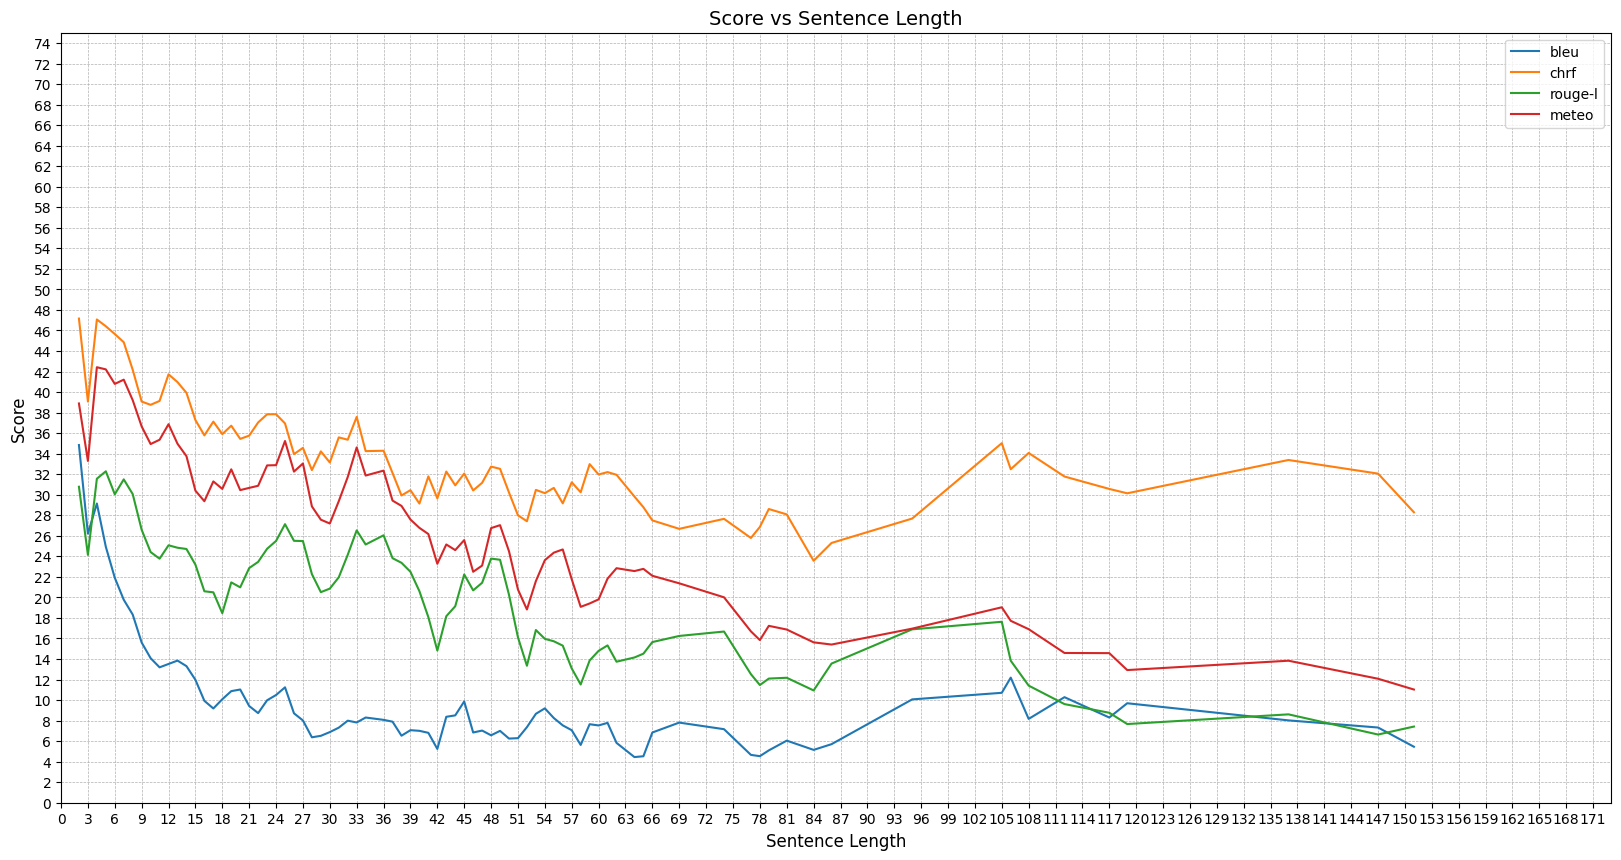

In [ ]:
import matplotlib.pyplot as plt


def SummarizeValuesBySentenceLength(score_type):
    bleus_gb_ref_length = defaultdict(list)

    # Iterate over each object and group the "deez" values by the length of "deez2"
    for obj in data:
        ref_len = len(obj['ref'].split(' '))
        #print(str(len(obj['ref'].split(' '))) + " " + obj['ref'])
        # if obj[score_type] <= 1:
        #     obj[score_type] = obj[score_type] * 100
        bleus_gb_ref_length[ref_len].append(obj[score_type])

    # Calculate the average of "deez" values for each group
    average_bleu_by_ref_len = {
        length: sum(values) / len(values)
        for length, values in bleus_gb_ref_length.items()
    }

    # Output the result
    average_bleu_by_ref_len = dict(sorted(average_bleu_by_ref_len.items()))
    #for length, avg in average_bleu_by_ref_len.items():
        #print(f"Average 'bleu' for 'ref' length {length}: {avg}")
    return average_bleu_by_ref_len
types = ["bleu", "chrf", "rouge-l", "meteo"]
dicts = []
for t in types:
    dicts.append(SummarizeValuesBySentenceLength(t))
# dicts = [SummarizeValuesBySentenceLength("bleu"), SummarizeValuesBySentenceLength("chrf"), SummarizeValuesBySentenceLength("rouge-l"), SummarizeValuesBySentenceLength("meteo")]

plt.figure(figsize=(20, 10))
for i in range(0, len(types)): #d in dicts:
    curr = dicts[i]
    print(curr[2])
    def moving_average(data, window_size):
        return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

    # Apply moving average to smooth the values
    smoothed_values = moving_average(list(curr.values()), window_size=3)

    # Adjust keys to match the length of the smoothed values
    smoothed_keys = list(curr.keys())[1:-1]
    plt.plot(smoothed_keys, smoothed_values, label=types[i])
    #plt.plot(list(curr.keys()), list(curr.values()), label=types[i])
    #plt.plot(i, d, color='blue', label='Model BLEU score')

# Add labels and title
plt.xlabel('Sentence Length', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Score vs Sentence Length', fontsize=14)

# Customize the grid and legend
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
print([max(length.values()) for length in dicts])
# Set limits for better visualization (if needed)
plt.xlim(0, max([max(length.keys()) for length in dicts]))
plt.ylim(0, 75)
plt.xticks([i for i in range(0, max([max(length.keys()) for length in dicts]))[::3]])
plt.yticks([i for i in range(0, 75)[::2]])


# Show the plot
plt.show()

In [ ]:
from transformers import AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained(f"/content/drive/MyDrive/Colab Notebooks/models/mt5-small/{args.output_dir}3_nb/")


In [ ]:
input = "Nikol Pashinyan ordered all servicemen, officers and generals of the Armed Forces to continue fulfilling their duty and preserving the territorial integrity of the RA borders."
expected = "Նիկոլ Փաշինեանը հրամայեց Զինուած ուժերու բոլոր զինուորներուն, սպաներուն, զօրապետերուն՝ զբաղիլ իրենց գործով՝ ՀՀ սահմաններու եւ տարածքային ամբողջականութեան պահպանմամբ։"

input_ids = tokenizer(input, return_tensors="pt").input_ids
outputs = model.generate(input_ids, max_length=128)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))
bleu = metric.compute(predictions=[tokenizer.decode(outputs[0], skip_special_tokens=True)], references=[[expected]])
print(bleu)